In [13]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load Dataset
print("Loading Dataset...")
df = pd.read_csv('sentence.csv')
print("Dataset Loaded")
print("First five rows of dataset")
df.head()


Loading Dataset...
Dataset Loaded
First five rows of dataset


,requirement_text,quality_label
0,The system should be efficient and easy to use.,Ambiguous
1,The system should be reliable and easy to use.,Ambiguous
2,The system must validate settings before reset...,Complete
3,The module must display notifications but skip...,Inconsistent
4,The software shall display error message when ...,Complete


In [3]:
# 3. Preprocessing Function

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = text.strip()
    return text

print("Check for null values:")
print(df.isna().sum())

print("Preprocessing the data...")
print("Converting to lower case...")
print("Removing whitespaces and unwanted characters...")
print("Removing leading and trailing whitespaces...")
df['clean_text'] = df['requirement_text'].apply(preprocess)
print("\nSample data after preprocessing")
df.head()

Check for null values:
requirement_text    0
quality_label       0
dtype: int64
Preprocessing the data...
Converting to lower case...
Removing whitespaces and unwanted characters...
Removing leading and trailing whitespaces...

Sample data after preprocessing


,requirement_text,quality_label,clean_text
0,The system should be efficient and easy to use.,Ambiguous,thesystemshouldbeefficientandeasytouse
1,The system should be reliable and easy to use.,Ambiguous,thesystemshouldbereliableandeasytouse
2,The system must validate settings before reset...,Complete,thesystemmustvalidatesettingsbeforeresettheirp...
3,The module must display notifications but skip...,Inconsistent,themodulemustdisplaynotificationsbutskipitunde...
4,The software shall display error message when ...,Complete,thesoftwareshalldisplayerrormessagewhenregistr...


In [4]:
# 4. Encode Labels

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['quality_label'])

# Display mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:\n", label_map)


Label Encoding Mapping:
 {'Ambiguous': np.int64(0), 'Complete': np.int64(1), 'Inconsistent': np.int64(2)}


In [5]:
# 5. Feature Extraction (TF-IDF)

vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label_enc']

print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)


Shape of X:  (700, 455)
Shape of y:  (700,)


In [6]:
# 6. Train-Test Split
print("Spliting training and testing data...\n")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)



Spliting training and testing data...

Shape of X_train:  (560, 455)
Shape of y_train:  (560,)
Shape of X_test:  (140, 455)
Shape of y_test:  (140,)


In [7]:
# 7. Train Base Models

svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

print("Training base models...")
print("Training SVM model...")
svm.fit(X_train, y_train)
print("Training Random Forest model...")
rf.fit(X_train, y_train)
print("Training Gradient Boosting model...")
gb.fit(X_train, y_train)
print("\nAll base models trained")


Training base models...
Training SVM model...
Training Random Forest model...
Training Gradient Boosting model...

All base models trained


In [8]:
# 8. Ensemble Model (Stacking)
stacking_clf = StackingClassifier(
    estimators=[('svm', svm), ('rf', rf), ('gb', gb)],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

# Train the stacking ensemble
print("Training Ensemble model...")
stacking_clf.fit(X_train, y_train)
print("Esemble model trained")

Training Ensemble model...
Esemble model trained


In [9]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f"\n{name} Results:")
    print(f"  Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
    print(f"  Train F1-Score: {train_f1:.4f} | Test F1-Score: {test_f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    return test_f1, test_acc, y_test_pred

# Models dictionary
models = {
    'SVM': svm,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Ensemble (Stacking)': stacking_clf
}

print("\nBASE + ENSEMBLE MODEL EVALUATION")

# Evaluate all models
results = {}
for name, model in models.items():
    f1, acc, pred = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results[name] = {'F1-Score': f1, 'Accuracy': acc, 'Predictions': pred}


BASE + ENSEMBLE MODEL EVALUATION

SVM Results:
  Train Accuracy: 1.0000 | Test Accuracy: 0.7071
  Train F1-Score: 1.0000 | Test F1-Score: 0.6377

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.54      1.00      0.70        48
           2       1.00      0.13      0.23        47

    accuracy                           0.71       140
   macro avg       0.85      0.71      0.64       140
weighted avg       0.84      0.71      0.64       140


Random Forest Results:
  Train Accuracy: 1.0000 | Test Accuracy: 0.7071
  Train F1-Score: 1.0000 | Test F1-Score: 0.6377

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.54      1.00      0.70        48
           2       1.00      0.13      0.23        47

    accuracy                           0.71       140
   macro avg       0.85      0.


📊 Model Comparison:
                 Model  Accuracy  F1-Score
0                  SVM  0.707143   0.63769
1        Random Forest  0.707143   0.63769
2    Gradient Boosting  0.707143   0.63769
3  Ensemble (Stacking)  0.707143   0.63769


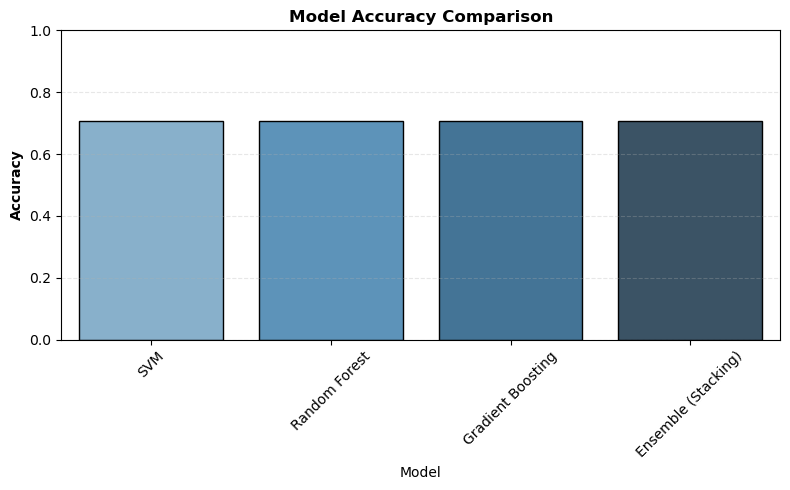

In [10]:
# STEP 10: Compare model performance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results dictionary to DataFrame
results_df = pd.DataFrame([
    {'Model': name, 'Accuracy': metrics['Accuracy'], 'F1-Score': metrics['F1-Score']}
    for name, metrics in results.items()
])

# Display comparison table
print("\n📊 Model Comparison:")
print(results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True))

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='Blues_d', edgecolor='black')
plt.title('Model Accuracy Comparison', fontweight='bold')
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

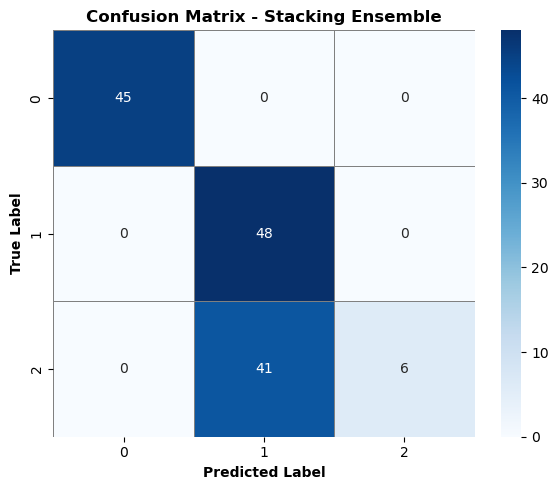

In [15]:
# STEP 11: Confusion Matrix for Stacking Model
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # or y_train if applicable
y_pred_stack = stacking_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_stack)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    linewidths=0.5, linecolor='gray'
)
plt.title("Confusion Matrix - Stacking Ensemble", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()